## Readme
### FlightRadar24 ETL Pipeline
Le présent projet implémente un pipeline ETL pour traiter les données de l'API FlightRadar24, qui répertorie l'ensemble des vols aériens, aéroports, et compagnies aériennes mondiales.

### Structure du Projet
Le projet contient :

Jupyter Notebook : Il sert de point de départ pour explorer et tester le pipeline ETL étape par étape. Il offre également une documentation détaillée des différentes étapes et méthodes utilisées.

Code Modulaire : Le pipeline ETL a été conçu de manière modulaire, divisé en plusieurs fichiers pour une meilleure organisation et lisibilité. Chaque fichier se concentre sur une tâche spécifique, assurant ainsi la séparation des préoccupations et une maintenance plus aisée.


### Architecture idéal
Exemple d'architecture idéal 

##### API FlightRadar24: 
Source principale des données sur le trafic aérien en temps réel.
##### Apache Airflow: 
Orchestre et planifie l'exécution du pipeline ETL, avec une interface visuelle pour le suivi.
##### Apache Spark: 
Assure le traitement distribué des données, permettant nettoyage, transformation et préparation pour le stockage.
##### Amazon S3/HDFS: 
Stockage final des données traitées, offrant rapidité, évolutivité et fiabilité.
##### ELK Stack: 
Centralise et visualise les journaux pour le monitoring en temps réel, garantissant une réponse rapide aux problèmes.

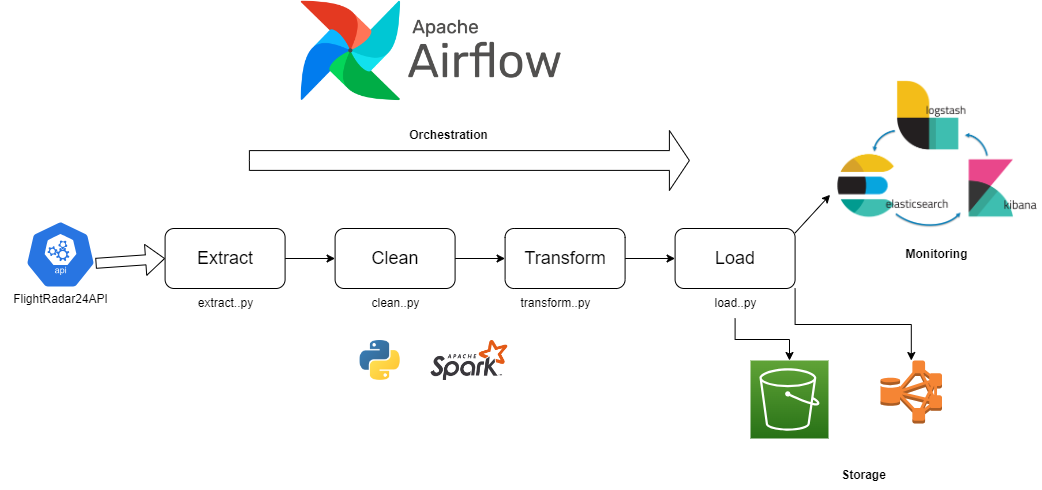

In [ ]:
%pip install FlightRadarAPI
%pip install pyspark
%pip install findspark
%pip install tqdm
%pip install pycountry_convert
%pip install flydenity

## Installation and Setup

In [1]:
import os
os.environ["JAVA_HOME"] = "C:\Java"
os.environ["SPARK_HOME"] = "C:\Spark"

In [2]:
import findspark
findspark.init()

In [43]:
from pyspark.sql import SparkSession
from FlightRadar24.api import FlightRadar24API
from datetime import datetime
import logging
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType
from pyspark.sql.functions import col
from tqdm import tqdm

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

from flydenity import Parser
parser = Parser()

from pyspark.sql.window import Window

In [4]:
# Initialiser session Spark
spark = SparkSession.builder \
    .appName("FlightRadar24 ETL Pipeline") \
    .master("local[*]") \
    .getOrCreate()
fr_api = FlightRadar24API()

In [5]:
spark

## Data Extraction

In [6]:
# Extraction des données
flights = fr_api.get_flights()
airports = fr_api.get_airports()
airlines = fr_api.get_airlines()

In [29]:
schema = StructType([
    StructField("latitude", StringType(), nullable=True),
    StructField("longitude", StringType(), nullable=True),
    StructField("altitude", StringType(), nullable=True),
    StructField("name", StringType(), nullable=True),
    StructField("icao", StringType(), nullable=True),
    StructField("iata", StringType(), nullable=True),
    StructField("country", StringType(), nullable=True)
])

In [7]:
flights_df = spark.createDataFrame(flights)
airports_df = spark.createDataFrame(airports, schema=schema)
airlines_df = spark.createDataFrame(airlines)

In [66]:
def fetch_flight_details(flights, max_retries=5, base_delay=2):
    flights_detailed = []
    flights_without_details = []   # Liste séparée pour les vols sans détails
    
    # Envelopper la liste des vols avec tqdm pour une barre de progression
    for flight in tqdm(flights, desc="Fetching flight details", unit="flight"):
        retries = 0
        fetched = False  # Indicateur permettant de vérifier si les détails ont été récupérés
        while retries < max_retries:
            try:
                flight_details = fr_api.get_flight_details(flight)
                flight.set_flight_details(flight_details)  
                flights_detailed.append(flight)  
                fetched = True
                break  
            except (CloudflareError, ConnectionError):
                retries += 1
                sleep_time = base_delay ** retries  # Exponential backoff
                time.sleep(sleep_time)
        
         # Si nous atteignons le nombre maximum de tentatives sans obtenir de détails, nous ajoutons le vol à la liste flights_without_details.
        if not fetched:
            flights_without_details.append(flight)
            
    return flights_detailed, flights_without_details

In [ ]:
flights_detailed_optimized, flights_missing_details = fetch_flight_details(flights)

In [148]:
# Convertir les objets de vol en dictionnaires
flights_as_dicts = [flight.__dict__ for flight in flights_detailed_optimized]

# Détecter les types incohérents
type_dict = defaultdict(set)

for flight_dict in flights_as_dicts:
    for key, value in flight_dict.items():
        type_dict[key].add(type(value))

# Identifier les clés dont les types sont incohérents
inconsistent_keys = {key for key, types in type_dict.items() if len(types) > 1}

# Harmoniser les types et convertir tout en chaîne pour les clés incohérentes
for flight_dict in flights_as_dicts:
    for key in inconsistent_keys:
        flight_dict[key] = str(flight_dict[key])  

# Créer le DataFrame après harmonisation
flights_detailed_df = spark.createDataFrame(flights_as_dicts)

In [81]:
def save_dataframe(df, base_folder, data_type, format="parquet"):
    """
    Sauvegarde un DataFrame Spark dans un dossier spécifique avec une nomenclature horodatée.
    
    Arguments:
    - df: DataFrame Spark à sauvegarder.
    - base_folder: Dossier principal (par exemple, 'ingest', 'cleaned', 'result').
    - data_type: Type de données (par exemple, 'Flights', 'Airports', 'Airlines').
    - format: Format de sauvegarde (par défaut, 'parquet').
    """
    
    # Obtenir l'horodatage actuel
    current_time = datetime.now()
    year_month = current_time.strftime("%Y-%m")
    day = current_time.strftime("%Y-%m-%d")
    timestamp = current_time.strftime("%Y%m%d%H%M%S")
    
    # Créer le chemin horodaté
    base_path = f"/data/{base_folder}/{data_type}"
    data_path = os.path.join(base_path, year_month, day, f"{data_type.lower()}_{timestamp}.{format}")
    
    # Sauvegarder le DataFrame
    if format == "parquet":
        df.write.parquet(data_path)
    elif format == "csv":
        df.write.csv(data_path)

    
    return data_path 

In [86]:
def read_dataframe(base_folder, data_type, specific_date=None, format="parquet"):
    """
    Lit un DataFrame Spark depuis un dossier spécifique avec une nomenclature horodatée.
    
    Arguments:
    - base_folder: Dossier principal (par exemple, 'ingest', 'cleaned', 'result').
    - data_type: Type de données (par exemple, 'Flights', 'Airports', 'Airlines').
    - specific_date: Date spécifique à partir de laquelle lire le DataFrame (par défaut, None pour la date actuelle).
    - format: Format de sauvegarde (par défaut, 'parquet').
    
    Retour:
    - DataFrame Spark chargé depuis le chemin spécifié.
    """
    
    # Si aucune date spécifique n'est fournie, utilisez l'horodatage actuel
    if specific_date is None:
        current_time = datetime.now()
        year_month = current_time.strftime("%Y-%m")
        day = current_time.strftime("%Y-%m-%d")
    else:
        year_month = specific_date.strftime("%Y-%m")
        day = specific_date.strftime("%Y-%m-%d")
    
    # Créer le chemin horodaté
    base_path = f"/data/{base_folder}/{data_type}"
    data_path = os.path.join(base_path, year_month, day)
    
    # Charger le DataFrame depuis le chemin spécifié
    if format == "parquet":
        df = spark.read.parquet(data_path)
    elif format == "csv":
        df = spark.read.csv(data_path)

    return df

In [82]:
save_dataframe(flights_df, "ingest", "Flights")
save_dataframe(airports_df, "ingest", "Airports")
save_dataframe(airlines_df, "ingest", "Airlines")
save_dataframe(flights_detailed_df, "ingest", "Flights_detailed")

Data saved to: /data/ingest/Flights\2023-08\2023-08-31\flights_20230831021757.parquet


## Cleaning

In [ ]:
flights_detailed_df = spark.read.parquet("/data/ingest/Flights_detailed/2023-08/2023-08-31/flights_detailed_20230831043117.parquet")

In [280]:
flights_detailed_df = flights_detailed_df.withColumn("aircraft_manufacturer", F.split(col("aircraft_model"), " ")[0])

In [281]:
country_corrections = {
    'Democratic Republic Of The Congo': 'Congo, The Democratic Republic of the',
    'Antigua And Barbuda': 'Antigua and Barbuda',
    'Reunion': 'Réunion',
    'Curacao':'Curaçao',
    'Saint Vincent And The Grenadines': 'Saint Vincent and the Grenadines',    
}

# UDF pour corriger les noms de pays
@udf(StringType())
def correct_country_name(country_name):
    return country_corrections.get(country_name, country_name)

flights_detailed_df = flights_detailed_df.withColumn(
    "origin_airport_country_name", 
    correct_country_name(col("origin_airport_country_name"))
)
flights_detailed_df = flights_detailed_df.withColumn(
    "destination_airport_country_name", 
    correct_country_name(col("destination_airport_country_name"))
)


In [282]:
# Convertir le nom du pays en code de continent
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

def country_to_continent(country):
    try:
        alpha2 = country_name_to_country_alpha2(country)
        continent_code = country_alpha2_to_continent_code(alpha2)
        return continents[continent_code]
    except:
        return None

convert_to_continent_udf = udf(country_to_continent, StringType())
flights_detailed_df = flights_detailed_df.withColumn("origin_continent", convert_to_continent_udf(col("origin_airport_country_name")))
flights_detailed_df = flights_detailed_df.withColumn("destination_continent", convert_to_continent_udf(col("destination_airport_country_name")))

In [283]:
flights_detailed_df = flights_detailed_df.withColumn("estimated_flight_duration", 
                       F.when(col("time_details.scheduled.arrival").isNotNull() & col("time_details.scheduled.departure").isNotNull(), 
                            col("time_details.scheduled.arrival") - col("time_details.scheduled.departure"))
                       .otherwise(None))

In [285]:
# UDF pour extraire le pays de l'aéronef à partir de son immatriculation
def registration_to_country(registration):
    try:
        return parser.parse(registration)['nation']
    except:
        return None 

registration_to_country_udf = udf(lambda x : registration_to_country(x) , StringType())
flights_detailed_df = flights_detailed_df.withColumn("aircraft_country", registration_to_country_udf(col("registration")))

In [309]:
columns_to_keep = ["id", "airline_iata", "origin_airport_country_code", "destination_airport_country_code", "latitude", "longitude", 
                   "destination_airport_latitude", "destination_airport_longitude", "aircraft_manufacturer", "aircraft_model", "registration",
                   "time_details", "origin_airport_iata", "destination_airport_iata", "origin_airport_country_name", "destination_airport_country_name", "origin_continent", "destination_continent",
                   "estimated_flight_duration", "aircraft_country"]
flights_detailed_enrichi_df = flights_detailed_df.select(columns_to_keep)

In [311]:
flights_detailed_enrichi_df = flights_detailed_enrichi_df.dropna(subset=["airline_iata", "origin_airport_country_code", "destination_airport_country_code", "aircraft_manufacturer"])

In [263]:
origin_countries_with_missing_continent.show()
destination_countries_with_missing_continent.show()

+---------------------------+
|origin_airport_country_code|
+---------------------------+
|                        N/A|
+---------------------------+

+--------------------------------+
|destination_airport_country_code|
+--------------------------------+
|                             N/A|
|                              VC|
+--------------------------------+



In [ ]:
# Extraire des noms de pays distincts pour l'origine et la destination
distinct_country_names = flights_detailed_df.select("origin_airport_country_name", "destination_airport_country_name").distinct().rdd.flatMap(lambda x: x).collect()

# Identifier les noms de pays qui ne sont pas standards
non_standard_countries = []

for country in distinct_country_names:
    try:
        country_name_to_country_alpha2(country)
    except:
        non_standard_countries.append(country)

non_standard_countries

In [314]:
save_dataframe(flights_detailed_enrichi_df, "enhanced", "Flights_detailed")

'/data/enhanced/Flights_detailed\\2023-08\\2023-08-31\\flights_detailed_20230831072843.parquet'

## Transform

# 1. La compagnie avec le + de vols en cours

In [339]:
# Grouper par IATA de la compagnie aérienne et compter le nombre de vols
most_active_airline = flights_detailed_enrichi_df.filter(F.col("airline_iata") != "N/A") \
    .groupBy("airline_iata") \
    .agg(F.count("*").alias("number_of_flights")) \
    .orderBy(F.desc("number_of_flights"))

# Joindre avec airlines_df pour obtenir le nom de la compagnie aérienne
result_1 = most_active_airline.join(airlines_df, most_active_airline.airline_iata == airlines_df.Code) \
    .select("Name", "number_of_flights") \
    .orderBy(F.desc("number_of_flights")) \
    

result_1.show(5)
save_dataframe(result_1, "result", "MostActiveAirline", format="csv")

+-----------------+-----------------+
|             Name|number_of_flights|
+-----------------+-----------------+
|  Delta Air Lines|               88|
|  United Airlines|               87|
|American Airlines|               74|
|         Emirates|               53|
|       Air Canada|               44|
+-----------------+-----------------+
only showing top 5 rows



'/data/result/MostActiveAirline\\2023-08\\2023-08-31\\mostactiveairline_20230831082606.csv'

# 2. Pour chaque continent, la compagnie avec le + de vols régionaux actifs (continent d'origine == continent de destination)


In [340]:
# Filtre pour les vols régionaux
regional_flights = flights_detailed_enrichi_df.filter(F.col("origin_continent") == F.col("destination_continent"))

# Groupez par continent et compagnie aérienne
grouped_data = regional_flights.groupBy("origin_continent", "airline_iata") \
    .agg(F.count("*").alias("number_of_flights"))

# Utilisez la fonction row_number pour obtenir le rang pour chaque compagnie aérienne par continent
windowSpec = Window.partitionBy("origin_continent").orderBy(F.desc("number_of_flights"))
ranked_data = grouped_data.withColumn("rank", F.row_number().over(windowSpec))

# Filtrez pour obtenir la compagnie aérienne avec le plus grand nombre de vols pour chaque continent
top_airline_per_continent = ranked_data.filter(F.col("rank") == 1) \
    .drop("rank") \
    .orderBy("origin_continent")

top_airline_per_continent.show()
save_dataframe(top_airline_per_continent, "result", "TopRegionalFlightsPerContinent", format="csv")

+----------------+------------+-----------------+
|origin_continent|airline_iata|number_of_flights|
+----------------+------------+-----------------+
|          Africa|          ET|                4|
|            Asia|          SV|               12|
|       Australia|          OD|                1|
|          Europe|         N/A|                5|
|   North America|          AA|               27|
|   South America|          AV|                3|
+----------------+------------+-----------------+



'/data/result/TopRegionalFlightsPerContinent\\2023-08\\2023-08-31\\topregionalflightspercontinent_20230831082632.csv'

# 3. Le vol en cours avec le trajet le plus long

In [341]:
# Joindre avec airlines_df pour obtenir le nom de la compagnie aérienne
result = flights_detailed_enrichi_df.join(airlines_df, 
                                          flights_detailed_enrichi_df.airline_iata == airlines_df.Code, 
                                          'left') \
                                   .orderBy(F.desc("estimated_flight_duration")) \
                                   .select("id", "estimated_flight_duration", "Name", 
                                           "origin_airport_country_name", "destination_airport_country_name")

result.show(1)
save_dataframe(result.limit(1), "result", "LongestFlight", format="csv")

+--------+-------------------------+-----------+---------------------------+--------------------------------+
|      id|estimated_flight_duration|       Name|origin_airport_country_name|destination_airport_country_name|
+--------+-------------------------+-----------+---------------------------+--------------------------------+
|31cfb839|               1693431820|Kalitta Air|                      Japan|                   United States|
+--------+-------------------------+-----------+---------------------------+--------------------------------+
only showing top 1 row



'/data/result/LongestFlight\\2023-08\\2023-08-31\\longestflight_20230831082720.csv'

# 4. Pour chaque continent, la longueur de vol moyenne

In [342]:
# Filtrer les vols régionaux
regional_flights = flights_detailed_enrichi_df.filter(F.col("origin_continent") == F.col("destination_continent"))

# Recalculer la durée estimée du vol
regional_flights = regional_flights.withColumn("estimated_flight_duration",
                                               F.when(col("time_details.scheduled.arrival") > col("time_details.scheduled.departure"),
                                                    col("time_details.scheduled.arrival") - col("time_details.scheduled.departure"))
                                               .otherwise(None))

# Calculer la durée moyenne du vol pour chaque continent
average_duration_per_continent = regional_flights.groupBy("origin_continent").agg(F.avg("estimated_flight_duration").alias("average_flight_duration"))

average_duration_per_continent.show()
save_dataframe(average_duration_per_continent, "result", "AvgFlightDurationPerContinent", format="csv")

+----------------+-----------------------+
|origin_continent|average_flight_duration|
+----------------+-----------------------+
|          Europe|     16975.384615384617|
|   North America|      19053.02068965517|
|            Asia|              26944.375|
|       Australia|                22600.0|
|          Africa|                17550.0|
|   South America|                22400.0|
+----------------+-----------------------+



'/data/result/AvgFlightDurationPerContinent\\2023-08\\2023-08-31\\avgflightdurationpercontinent_20230831082741.csv'

# 5. L'entreprise constructeur d'avions avec le plus de vols actifs

In [343]:
result_5 = flights_detailed_enrichi_df.filter(F.col("aircraft_manufacturer") != "N/A") \
    .groupBy("aircraft_manufacturer") \
    .agg(F.count("*").alias("number_of_flights")) \
    .orderBy(F.desc("number_of_flights")) \
    
result_5.show(5)
save_dataframe(result_5, "result", "MostActiveAircraftManufacturer", format="csv")

+---------------------+-----------------+
|aircraft_manufacturer|number_of_flights|
+---------------------+-----------------+
|               Boeing|              827|
|               Airbus|              495|
|           Gulfstream|               17|
|           Bombardier|               16|
|               Cessna|               15|
+---------------------+-----------------+
only showing top 5 rows



'/data/result/MostActiveAircraftManufacturer\\2023-08\\2023-08-31\\mostactiveaircraftmanufacturer_20230831082753.csv'

# 6. Pour chaque pays de compagnie aérienne, le top 3 des modèles d'avion en usage

In [344]:
from pyspark.sql.window import Window

windowSpec = Window.partitionBy("aircraft_country").orderBy(F.desc("count"))

top_aircrafts = flights_detailed_enrichi_df.filter(F.col("aircraft_country").isNotNull()) \
                                          .groupBy("aircraft_country", "aircraft_model") \
                                          .agg(F.count("*").alias("count"))

result_6 = top_aircrafts.withColumn("rank", F.row_number().over(windowSpec)) \
             .filter((F.col("rank") <= 3) & (F.col("aircraft_country").isNotNull())) \
             

result_6.show() 
save_dataframe(result_6, "result", "Top3AircraftsPerCountry", format="csv")

+----------------+--------------------+-----+----+
|aircraft_country|      aircraft_model|count|rank|
+----------------+--------------------+-----+----+
|         Algeria|     Airbus A330-202|    1|   1|
|           Aruba|Bombardier Challe...|    1|   1|
|           Aruba|     Gulfstream G550|    1|   2|
|       Australia|Boeing 787-9 Drea...|   10|   1|
|       Australia|     Airbus A330-303|    5|   2|
|       Australia|     Airbus A380-842|    2|   3|
|         Austria|  Boeing 767-3Z9(ER)|    2|   1|
|         Austria|  Boeing 777-2Z9(ER)|    2|   2|
|         Austria|     Boeing 747-412F|    1|   3|
|         Bahrain|Boeing 767-323(ER...|    1|   1|
|      Bangladesh|Boeing 787-8 Drea...|    1|   1|
|      Bangladesh|      Boeing 737-8HO|    1|   2|
|         Belarus|      Boeing 737-8ZM|    1|   1|
|         Belarus|    Boeing 737 MAX 8|    1|   2|
|         Belgium|     Airbus A330-343|    5|   1|
|         Belgium|Boeing 787-8 Drea...|    2|   2|
|         Belgium|         Libe

'/data/result/Top3AircraftsPerCountry\\2023-08\\2023-08-31\\top3aircraftspercountry_20230831082806.csv'

# Question Bonus

In [345]:
departures = flights_detailed_enrichi_df.groupBy("origin_airport_iata").agg(F.count("*").alias("departures"))
arrivals = flights_detailed_enrichi_df.groupBy("destination_airport_iata").agg(F.count("*").alias("arrivals"))

difference_with_diff = (
    departures.join(arrivals, departures.origin_airport_iata == arrivals.destination_airport_iata, "outer")
    .fillna(0)
    .withColumn("diff", F.abs(F.col("departures") - F.col("arrivals")))
)

# Joindre avec airports_df pour obtenir le nom de l'aéroport
result_bonus = (
    difference_with_diff.join(airports_df, difference_with_diff.origin_airport_iata == airports_df.iata)
    .select("name", "departures", "arrivals", "diff")
    .orderBy(F.desc("diff"))
    
)

result_bonus.show(5)
save_dataframe(result_bonus, "result", "AirportMaxDiffDepartureArrival", format="csv")

+--------------------+----------+--------+----+
|                name|departures|arrivals|diff|
+--------------------+----------+--------+----+
|   Frankfurt Airport|        61|       6|  55|
|Paris Charles de ...|        60|       7|  53|
|Amsterdam Schipho...|        54|       5|  49|
|New York John F. ...|        34|      74|  40|
|London Heathrow A...|        74|      34|  40|
+--------------------+----------+--------+----+
only showing top 5 rows



'/data/result/AirportMaxDiffDepartureArrival\\2023-08\\2023-08-31\\airportmaxdiffdeparturearrival_20230831082824.csv'